<a href="https://colab.research.google.com/github/KevinTheRainmaker/Recommendation_Algorithms/blob/main/colab/fastcampus/Matrix_Factorization_Trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matrix Factorization

- MovieLens 데이터셋 활용
- SVD를 직접 구현하고, 적절한 k값 찾기
- matrix factorization을 간단히 할 수 있는 파이썬 라이브러리 소개

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import packages

In [44]:
import os
import pandas as pd
import numpy as np
from math import sqrt
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

## Load Dataset

In [45]:
path = '/content/drive/MyDrive/data/movielens'
ratings_df = pd.read_csv(os.path.join(path, 'ratings.csv'), encoding='utf-8')

In [46]:
ratings_df.shape

(100836, 4)

In [47]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [48]:
ratings_df['userId'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [49]:
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=1234)

print(train_df.shape)
print(test_df.shape)

(80668, 4)
(20168, 4)


### Make Sparse Matrix

In [50]:
sparse_matrix = train_df.groupby('movieId').apply(lambda x : pd.Series(x['rating'].values, index=x['userId'])).unstack()
sparse_matrix.index.name = 'movieId'

In [51]:
# fill sparse matrix with average of movie ratings
sparse_matrix_withmovie = sparse_matrix.apply(lambda x: x.fillna(x.mean()), axis=1)

# fill sparse matrix with average of user ratings
sparse_matrix_withuser = sparse_matrix.apply(lambda x: x.fillna(x.mean()), axis=0)

In [52]:
print(sparse_matrix_withmovie.shape)
print(sparse_matrix_withuser.shape)

(8938, 610)
(8938, 610)


## Matrix Factorization with SVD

In [53]:
def get_svd(s_matrix, k=300):
  u, s, vt = np.linalg.svd(s_matrix.transpose()) # left singular vector u / right singular vector vt
  S = s[:k] * np.identity(k, np.float)
  T = u[:, :k]
  Dt = vt[:k, :]

  item_factors = np.transpose(np.matmul(S,Dt))
  user_factors = np.transpose(T)

  return item_factors, user_factors

### 1. with average movie ratings

In [54]:
item_factors, user_factors = get_svd(sparse_matrix_withmovie)
prediction_result_df = pd.DataFrame(np.matmul(item_factors, user_factors),
                                    columns=sparse_matrix_withmovie.columns.values,
                                    index=sparse_matrix_withmovie.index.values)

movie_prediction_result_df = prediction_result_df.transpose()

In [55]:
print(item_factors.shape)
print(user_factors.shape)

(8938, 300)
(300, 610)


In [56]:
movie_prediction_result_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,184257,184349,184471,184721,184791,184931,184987,184997,185033,185135,185435,185585,187031,187541,187593,187595,187717,188189,188301,188675,188797,189043,189111,189333,189547,190183,190207,190209,190213,190215,190219,191005,193565,193567,193571,193573,193579,193581,193587,193609
1,3.908820,3.390957,4.035030,2.252912,3.053903,3.981066,3.183727,2.744891,2.909088,3.505548,3.706015,2.374035,3.123550,3.933145,2.971819,3.911682,3.793296,3.616735,2.723460,2.714942,3.467551,3.257282,3.125723,3.116005,3.666359,3.445724,3.481224,4.057030,3.950146,3.003699,3.127470,4.045563,3.725531,3.732041,2.000468,3.322564,3.499942,3.799698,3.176480,3.187039,...,3.999934,3.499942,2.498336,3.999934,3.249974,3.999934,2.999950,3.999934,1.999967,4.749644,2.999950,2.750140,3.251965,3.505465,4.126688,3.501081,4.999917,4.499925,3.500506,3.499942,3.999934,2.499959,2.999950,3.999934,0.999983,3.499942,1.499975,3.999934,0.999983,1.499975,0.999983,4.499925,3.499942,2.999950,3.999934,3.999934,3.499942,3.999934,3.499942,3.999934
2,3.911434,3.445683,3.461056,2.240729,2.998555,3.959505,3.151831,2.751379,2.910568,3.406105,3.706765,2.358869,3.126824,3.946110,3.016277,3.840996,3.829437,3.635910,2.722463,2.741404,3.493050,3.267066,3.185609,3.081252,3.647671,3.423465,3.500961,4.075291,3.973008,3.001640,3.126769,3.953079,3.763999,3.739251,2.000506,3.327100,3.499797,3.803588,3.171343,3.168945,...,3.999768,3.499797,2.494128,3.999768,3.255965,3.999768,2.999826,3.999768,1.999884,4.757657,2.999826,2.749987,3.251145,3.489683,4.160032,3.494873,4.999710,4.499739,3.505032,3.499797,3.999768,2.499855,2.999826,3.999768,0.999942,3.499797,1.499913,3.999768,0.999942,1.499913,0.999942,4.499739,3.499797,2.999826,3.999768,3.999768,3.499797,3.999768,3.499797,3.999768
3,3.896327,3.383747,3.439498,2.240612,3.049043,3.935766,3.174809,2.738581,2.910505,3.515399,3.705274,2.346706,3.117167,3.950714,3.000556,3.900426,3.825145,3.602151,2.735374,2.730128,3.429712,3.272879,3.139803,3.148035,3.701209,3.462291,3.481890,4.047783,3.947432,2.993830,0.449036,3.979410,3.709393,3.738304,2.001326,3.303376,3.500003,3.810915,3.161767,3.195110,...,4.000004,3.500003,2.495915,4.000004,3.249723,4.000004,3.000003,4.000004,2.000002,4.749722,3.000003,2.749922,3.254521,3.505089,4.148535,3.498766,5.000005,4.500004,3.499708,3.500003,4.000004,2.500002,3.000003,4.000004,1.000001,3.500003,1.500001,4.000004,1.000001,1.500001,1.000001,4.500004,3.500003,3.000003,4.000004,4.000004,3.500003,4.000004,3.500003,4.000004
4,3.881024,3.421886,3.427186,2.239842,3.057280,3.946683,3.197075,2.748549,2.921073,3.513596,3.709638,2.330166,3.129011,3.946833,2.992122,3.928751,3.817044,3.623509,2.749023,2.709416,2.999745,3.281466,3.146324,3.105717,3.659938,3.462677,3.478352,4.052634,3.926144,2.994820,3.182435,1.983056,3.736292,3.761480,2.001490,3.283147,3.499933,3.795573,3.170177,3.194634,...,3.999923,3.499933,2.500395,3.999923,3.251140,3.999923,2.999942,3.999923,1.999962,4.748841,2.999942,2.749860,3.256529,3.505547,4.145955,3.500337,4.999904,4.499913,3.502930,3.499933,3.999923,2.499952,2.999942,3.999923,0.999981,3.499933,1.499971,3.999923,0.999981,1.499971,0.999981,4.499913,3.499933,2.999942,3.999923,3.999923,3.499933,3.999923,3.499933,3.999923
5,4.018416,3.400912,3.493598,2.184629,3.156865,3.946429,3.246271,2.874286,2.903455,3.256205,3.837746,2.257888,3.091730,3.976458,2.982567,3.866928,3.457249,3.638830,2.668557,2.657656,3.884664,3.295209,3.172401,2.911738,3.736052,3.431177,3.461068,4.039688,3.996906,2.965153,3.146463,4.077958,3.686273,3.870821,2.001778,3.067054,3.500120,3.804698,3.175492,3.171672,...,4.000138,3.500120,2.483630,4.000138,3.249906,4.000138,3.000103,4.000138,2.000069,4.749042,3.000103,2.752446,3.241694,3.502344,4.092567,3.491996,5.000172,4.500155,3.508815,3.500120,4.000138,2.500086,3.000103,4.000138,1.000034,3.500120,1.500052,4.000138,1.000034,1.500052,1.000034,4.500155,3.500120,3.000103,4.000138,4.000138,3.500120,4

### 2. with average user ratings

In [57]:
item_factors, user_factors = get_svd(sparse_matrix_withuser)
prediction_result_df = pd.DataFrame(np.matmul(item_factors, user_factors),
                                    columns=sparse_matrix_withuser.columns.values,
                                    index=sparse_matrix_withuser.index.values)

user_prediction_result_df = prediction_result_df.transpose()

In [58]:
user_prediction_result_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,184257,184349,184471,184721,184791,184931,184987,184997,185033,185135,185435,185585,187031,187541,187593,187595,187717,188189,188301,188675,188797,189043,189111,189333,189547,190183,190207,190209,190213,190215,190219,191005,193565,193567,193571,193573,193579,193581,193587,193609
1,4.362666,4.366280,3.966290,4.335373,4.363704,3.983660,4.303573,4.339269,4.305649,4.254211,4.282134,4.272191,4.305426,4.292480,4.367508,4.329744,4.236116,4.315804,4.335157,4.349928,4.390426,4.328058,4.333100,4.285464,4.297623,4.293682,4.293528,4.319689,4.356478,4.329777,4.321528,4.346353,4.321307,4.352456,4.322469,4.311651,4.336900,4.315834,4.319297,4.310632,...,4.320553,4.320659,4.319881,4.320247,4.320783,4.320052,4.320922,4.319682,4.321792,4.319183,4.320103,4.320393,4.321417,4.343645,4.316166,4.320900,4.319551,4.319899,4.319971,4.321276,4.320052,4.319997,4.320593,4.320508,4.338351,4.321614,4.318804,4.321786,4.318208,4.318804,4.318208,4.320182,4.320834,4.321160,4.320508,4.320508,4.320834,4.320508,4.320834,4.321664
2,4.018066,3.941879,3.903070,3.960808,3.907779,3.993262,3.913604,3.941605,3.919774,3.880579,3.943441,3.918753,3.942259,3.949975,3.945655,3.897922,4.026012,3.962097,3.916821,3.927611,3.939632,3.939612,3.967440,3.959351,3.898365,3.929732,3.950717,3.966032,3.944258,3.943119,3.921734,3.899026,3.973978,3.966196,3.939077,3.943800,3.942287,3.925650,3.936770,3.931904,...,3.943699,3.940000,3.937679,3.938932,3.942038,3.940905,3.939593,3.947036,3.938280,3.913061,3.935446,3.946262,3.938680,3.914377,3.948401,3.940092,3.937104,3.938018,3.946582,3.942487,3.940905,3.935944,3.939630,3.941626,3.947114,3.938485,3.928572,3.947002,3.924886,3.928572,3.924886,3.945287,3.937965,3.934304,3.941626,3.941626,3.937965,3.941626,3.937965,3.940416
3,2.503743,2.498854,2.491555,2.529266,2.509395,2.519116,2.486491,2.511599,2.508844,2.517707,2.511558,2.514186,2.516351,2.554171,2.534299,2.479551,2.544206,2.512989,2.491814,2.504471,2.503388,2.517612,2.511993,2.530817,2.516081,2.513982,2.516984,2.517356,2.495134,2.513022,0.383380,2.518260,2.492373,2.525631,2.518249,2.479970,2.513929,2.519828,2.517863,2.516064,...,2.516750,2.516683,2.515888,2.515541,2.516895,2.517157,2.516447,2.515947,2.515737,2.514842,2.517383,2.517969,2.516073,2.522945,2.515949,2.516545,2.513610,2.514575,2.516228,2.516513,2.517157,2.519283,2.516905,2.516569,2.524595,2.517604,2.524039,2.512149,2.526417,2.524039,2.526417,2.516350,2.516789,2.517009,2.516569,2.516569,2.516789,2.516569,2.516789,2.516032
4,3.624253,3.635961,3.619964,3.641844,3.632798,3.643807,3.636671,3.642801,3.615370,3.632327,3.607290,3.649405,3.631232,3.640977,3.642348,3.633410,3.643807,3.632953,3.656087,3.642907,3.010115,3.641869,3.637811,3.641900,3.600203,3.624221,3.629186,3.639269,3.621811,3.632938,3.642877,1.975800,3.649815,3.633827,3.632849,3.597837,3.631389,3.620023,3.636043,3.621379,...,3.632061,3.631896,3.634660,3.631660,3.632287,3.631393,3.632082,3.630840,3.632771,3.632925,3.632303,3.632957,3.632240,3.641846,3.632617,3.632179,3.631302,3.631481,3.630569,3.631749,3.631393,3.631816,3.631864,3.632119,3.642411,3.630964,3.631722,3.631958,3.631674,3.631722,3.631674,3.632685,3.631554,3.630989,3.632119,3.632119,3.631554,3.632119,3.631554,3.632004
5,4.051183,3.581114,3.721059,3.627674,3.519383,3.536805,3.768194,3.682646,3.571370,3.639438,3.758502,3.716790,3.593090,3.739135,3.544159,3.638336,3.573450,3.685931,3.703388,3.602880,3.767780,3.647955,3.633116,3.579576,3.781266,3.683309,3.644241,3.618433,3.674949,3.609795,3.644883,3.645444,3.694475,3.824025,3.630491,2.994323,3.637913,3.638693,3.650969,3.604851,...,3.634138,3.636475,3.619286,3.641151,3.637461,3.638865,3.635243,3.639514,3.631621,3.629838,3.637322,3.631094,3.633085,3.625826,3.694962,3.635317,3.649354,3.645253,3.637108,3.637206,3.638865,3.622887,3.635139,3.636919,3.664728,3.628336,3.598384,3.659643,3.586132,3.598384,3.586132,3.638168,3.635671,3.634422,3.636919,3.636919,3.635671,3

## Compare user and movie scenario

In [59]:
def evaluate(test_df, prediction_result_df):
  groups_with_movie_ids = test_df.groupby(by='movieId')
  groups_with_user_ids = test_df.groupby(by='userId')
  intersection_movie_ids = sorted(list(set(list(prediction_result_df.columns)).intersection(set(list(groups_with_movie_ids.indices.keys())))))
  intersection_user_ids = sorted(list(set(list(prediction_result_df.index)).intersection(set(groups_with_user_ids.indices.keys()))))

  print(len(intersection_movie_ids))
  print(len(intersection_user_ids))

  compressed_prediction_df = prediction_result_df.loc[intersection_user_ids][intersection_movie_ids]

  # test_df에 대해서 RMSE 계산
  grouped = test_df.groupby(by='userId')
  rmse_df = pd.DataFrame(columns=['rmse'])
  for userId, group in tqdm(grouped):
      if userId in intersection_user_ids:
          pred_ratings = compressed_prediction_df.loc[userId][compressed_prediction_df.loc[userId].index.intersection(list(group['movieId'].values))]
          pred_ratings = pred_ratings.to_frame(name='rating').reset_index().rename(columns={'index':'movieId','rating':'pred_rating'})
          actual_ratings = group[['rating', 'movieId']].rename(columns={'rating':'actual_rating'})

          final_df = pd.merge(actual_ratings, pred_ratings, how='inner', on=['movieId'])
          final_df = final_df.round(4) # 반올림
          
          if not final_df.empty:
            rmse = sqrt(mean_squared_error(final_df['actual_rating'], final_df['pred_rating']))
            rmse_df.loc[userId] = rmse

  return final_df, rmse_df

In [60]:
result_df, _ = evaluate(test_df, user_prediction_result_df)
print(result_df)
print("For user matrix")
print(f"RMSE: {sqrt(mean_squared_error(result_df['actual_rating'].values, result_df['pred_rating'].values))}")

4385
610


  0%|          | 0/610 [00:00<?, ?it/s]

     actual_rating  movieId  pred_rating
0              5.0     3527       3.6789
1              3.5    84772       3.6783
2              3.5   103141       3.6758
3              4.0    81132       3.6785
4              4.5   130634       3.6785
..             ...      ...          ...
218            4.0   106100       3.6805
219            4.0   111759       3.6747
220            1.0     4852       3.6787
221            3.0     2628       3.6883
222            5.0     1953       3.6721

[223 rows x 3 columns]
For user matrix
RMSE: 0.8551691150767583


In [61]:
result_df, _ = evaluate(test_df, movie_prediction_result_df)
print(result_df)
print("For movie matrix")
print(f"RMSE: {sqrt(mean_squared_error(result_df['actual_rating'].values, result_df['pred_rating'].values))}")

4385
610


  0%|          | 0/610 [00:00<?, ?it/s]

     actual_rating  movieId  pred_rating
0              5.0     3527       3.6030
1              3.5    84772       3.0433
2              3.5   103141       4.0453
3              4.0    81132       3.5000
4              4.5   130634       3.2496
..             ...      ...          ...
218            4.0   106100       3.8314
219            4.0   111759       3.9239
220            1.0     4852       1.0000
221            3.0     2628       3.1901
222            5.0     1953       3.8234

[223 rows x 3 columns]
For movie matrix
RMSE: 0.8209361471321392


## Experiments on different k with grid search

In [62]:
def find_best_k(sparse_matrix, maximum_k=100):
    print("\nFind best optimized k for Matrix Factorization")
    k_candidates = np.arange(50, maximum_k, 10)
    final_df = pd.DataFrame(columns=['rmse'], index=k_candidates)
    for k in tqdm(k_candidates):
        item_factors, user_factors = get_svd(sparse_matrix, k)
        each_results_df = pd.DataFrame(np.matmul(item_factors, user_factors),
                                    columns=sparse_matrix.columns.values, index=sparse_matrix.index.values)
        each_results_df = each_results_df.transpose()
        
        result_df, _ = evaluate(test_df, each_results_df)
        each_rmse = sqrt(mean_squared_error(result_df['actual_rating'].values, result_df['pred_rating'].values))

        final_df.loc[k]['rmse'] = each_rmse

    return final_df

In [64]:
res = find_best_k(sparse_matrix_withmovie, 200)


Find best optimized k for Matrix Factorization


  0%|          | 0/15 [00:00<?, ?it/s]

4385
610


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


  0%|          | 0/610 [00:00<?, ?it/s]

In [82]:
res.sort_values(by = 'rmse').index[0]

150

### Visualize

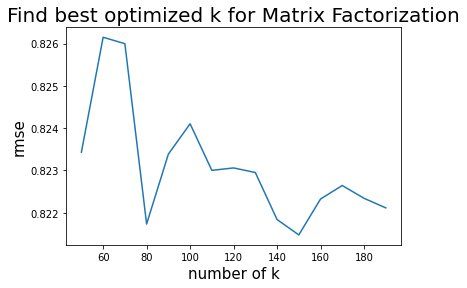

In [83]:
plt.plot(res.index, res.rmse)
plt.title("Find best optimized k for Matrix Factorization", fontsize=20)
plt.xlabel('number of k', fontsize=15)
plt.ylabel('rmse', fontsize=15)
plt.show()

## Matrix Factorization with Simple Python module

- https://pypi.org/project/matrix-factorization/

In [1]:
!pip install -q matrix-factorization

In [2]:
from matrix_factorization import BaselineModel, KernelMF, train_update_test_split

In [6]:
path = '/content/drive/MyDrive/data/movielens'
ratings_df = pd.read_csv(os.path.join(path, 'ratings.csv'), encoding='utf-8')

print(ratings_df.shape)
print(ratings_df.head())

(100836, 4)
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [7]:
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=1234)

print(train_df.shape)
print(test_df.shape)

(80668, 4)
(20168, 4)


In [8]:
train_df.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [9]:
new_train_df = train_df
new_train_df = new_train_df.rename(columns={"userId": "user_id", "movieId": "item_id"})
new_train_df.head()

,user_id,item_id,rating,timestamp
95713,600,5943,3.0,1237714356
61560,407,2571,5.0,1424349171
77204,482,8958,4.0,1105397126
93367,599,2322,2.5,1498515283
90892,590,2959,3.5,1258416553


In [10]:
(
    X_train_initial,
    y_train_initial,
    X_train_update,
    y_train_update,
    X_test_update,
    y_test_update,
) = train_update_test_split(new_train_df, frac_new_users=0.2)

In [15]:
# Initial training
matrix_fact = KernelMF(n_epochs=20, n_factors=100, verbose=1, lr=0.001, reg=0.005)
matrix_fact.fit(X_train_initial, y_train_initial)

Epoch  1 / 20  -  train_rmse: 0.9805803485075361
Epoch  2 / 20  -  train_rmse: 0.9559053812884625
Epoch  3 / 20  -  train_rmse: 0.9393815003858484
Epoch  4 / 20  -  train_rmse: 0.9269035365748026
Epoch  5 / 20  -  train_rmse: 0.9168645269607241
Epoch  6 / 20  -  train_rmse: 0.9084340791101375
Epoch  7 / 20  -  train_rmse: 0.9010979240172103
Epoch  8 / 20  -  train_rmse: 0.8946199984674614
Epoch  9 / 20  -  train_rmse: 0.8887859701845864
Epoch  10 / 20  -  train_rmse: 0.8834209586307645
Epoch  11 / 20  -  train_rmse: 0.8784564576357888
Epoch  12 / 20  -  train_rmse: 0.8738215448986383
Epoch  13 / 20  -  train_rmse: 0.8694504952267851
Epoch  14 / 20  -  train_rmse: 0.8652953249661798
Epoch  15 / 20  -  train_rmse: 0.8613261339649324
Epoch  16 / 20  -  train_rmse: 0.857520192389102
Epoch  17 / 20  -  train_rmse: 0.8538489735377403
Epoch  18 / 20  -  train_rmse: 0.8502948563171918
Epoch  19 / 20  -  train_rmse: 0.8468448254845153
Epoch  20 / 20  -  train_rmse: 0.843478438815152


KernelMF(gamma=0.01, lr=0.001, n_epochs=20, reg=0.005)

In [16]:
# Update model with new users
matrix_fact.update_users(
    X_train_update, y_train_update, lr=0.001, n_epochs=20, verbose=1
)

Epoch  1 / 20  -  train_rmse: 0.9799739056448565
Epoch  2 / 20  -  train_rmse: 0.9620578872047366
Epoch  3 / 20  -  train_rmse: 0.9500636878828986
Epoch  4 / 20  -  train_rmse: 0.9412792633219204
Epoch  5 / 20  -  train_rmse: 0.93456781574128
Epoch  6 / 20  -  train_rmse: 0.929248100831644
Epoch  7 / 20  -  train_rmse: 0.9248543217308992
Epoch  8 / 20  -  train_rmse: 0.9211458802677496
Epoch  9 / 20  -  train_rmse: 0.9179306620667371
Epoch  10 / 20  -  train_rmse: 0.9150866672467488
Epoch  11 / 20  -  train_rmse: 0.912549498505068
Epoch  12 / 20  -  train_rmse: 0.9102436945850512
Epoch  13 / 20  -  train_rmse: 0.9081160385686408
Epoch  14 / 20  -  train_rmse: 0.9061461865008472
Epoch  15 / 20  -  train_rmse: 0.9042971022578699
Epoch  16 / 20  -  train_rmse: 0.9025606635412102
Epoch  17 / 20  -  train_rmse: 0.9009124249940773
Epoch  18 / 20  -  train_rmse: 0.899342969960476
Epoch  19 / 20  -  train_rmse: 0.8978402584626333
Epoch  20 / 20  -  train_rmse: 0.8963976545225477


In [17]:
pred = matrix_fact.predict(X_test_update)
rmse = mean_squared_error(y_test_update, pred, squared=False)
print(f"\nTest RMSE: {rmse:.4f}")


Test RMSE: 0.9477


In [29]:
# Get recommendations
items_known = X_train_initial.query("user_id == @user")["item_id"]
result = matrix_fact.recommend(user=1, items_known=items_known)
# users = [2, 3, 4]
# for user in users:
#   items_known = X_train_initial.query("user_id == @user")["item_id"]
#   temp = matrix_fact.recommend(user=user, items_known=items_known)
#   result = pd.concat([result, temp], axis = 1)
result

,user_id,item_id,rating_pred
445,1,50,5.000000
561,1,260,5.000000
457,1,318,4.992976
320,1,356,4.992341
789,1,2959,4.928253
73,1,2571,4.923123
62,1,858,4.920213
142,1,1196,4.914728
282,1,1198,4.868346
553,1,7153,4.868319


In [84]:
from matrix_factorization import BaselineModel, KernelMF, train_update_test_split

def find_best_k(sparse_matrix, maximum_k=100):
    print("\nFind best optimized k for Matrix Factorization")
    k_candidates = np.arange(50, maximum_k, 10)
    final_df = pd.DataFrame(columns=['rmse'], index=k_candidates)
    for k in tqdm(k_candidates):
        item_factors, user_factors = get_svd(sparse_matrix, k)
        each_results_df = pd.DataFrame(np.matmul(item_factors, user_factors),
                                    columns=sparse_matrix.columns.values, index=sparse_matrix.index.values)
        each_results_df = each_results_df.transpose()
        
        result_df, _ = evaluate(test_df, each_results_df)
        each_rmse = sqrt(mean_squared_error(result_df['actual_rating'].values, result_df['pred_rating'].values))

        final_df.loc[k]['rmse'] = each_rmse

    return final_df

res = find_best_k(sparse_matrix_withmovie, 200)
best_k = int(res['rmse'].sort_values().index[0])
print(best_k)

path = '/content/drive/MyDrive/data/movielens'
ratings_df = pd.read_csv(os.path.join(path, 'ratings.csv'), encoding='utf-8')
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=1234)
new_train_df = train_df
new_train_df = new_train_df.rename(columns={"userId": "user_id", "movieId": "item_id"})

(
    X_train_initial,
    y_train_initial,
    X_train_update,
    y_train_update,
    X_test_update,
    y_test_update,
) = train_update_test_split(new_train_df, frac_new_users=0.2)

# Initial training
matrix_fact = KernelMF(n_epochs=20, n_factors=best_k, verbose=0, lr=0.001, reg=0.005)
matrix_fact.fit(X_train_initial, y_train_initial)

# Update model with new users
matrix_fact.update_users(
    X_train_update, y_train_update, lr=0.001, n_epochs=20, verbose=1
)

# Get recommendations
users = [x for x in range(2, 611)]
items_known = X_train_initial.query("user_id == @user")["item_id"]
result = matrix_fact.recommend(user=1, items_known=items_known)
for user in tqdm(users):
  items_known = X_train_initial.query("user_id == @user")["item_id"]
  temp = matrix_fact.recommend(user=user, items_known=items_known)
  result = pd.concat([result, temp], axis = 1)


Find best optimized k for Matrix Factorization


  0%|          | 0/15 [00:00<?, ?it/s]

4385
610


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


  0%|          | 0/610 [00:00<?, ?it/s]

150
Epoch  1 / 20  -  train_rmse: 0.9871599794471125
Epoch  2 / 20  -  train_rmse: 0.9744079924675783
Epoch  3 / 20  -  train_rmse: 0.9656859791925518
Epoch  4 / 20  -  train_rmse: 0.9587624554855477
Epoch  5 / 20  -  train_rmse: 0.9528470603212004
Epoch  6 / 20  -  train_rmse: 0.9475953352972835
Epoch  7 / 20  -  train_rmse: 0.9428853901579416
Epoch  8 / 20  -  train_rmse: 0.9385846529787338
Epoch  9 / 20  -  train_rmse: 0.9346247997002167
Epoch  10 / 20  -  train_rmse: 0.930955631069409
Epoch  11 / 20  -  train_rmse: 0.9275304096159255
Epoch  12 / 20  -  train_rmse: 0.9243165074002574
Epoch  13 / 20  -  train_rmse: 0.92129189330244
Epoch  14 / 20  -  train_rmse: 0.9184357242985157
Epoch  15 / 20  -  train_rmse: 0.9157213630939333
Epoch  16 / 20  -  train_rmse: 0.9131377156105831
Epoch  17 / 20  -  train_rmse: 0.9106714725269105
Epoch  18 / 20  -  train_rmse: 0.908302964700225
Epoch  19 / 20  -  train_rmse: 0.9060310723147695
Epoch  20 / 20  -  train_rmse: 0.9038450182272694


  0%|          | 0/609 [00:00<?, ?it/s]

In [85]:
result.to_csv('./drive/MyDrive/data/trial_result.csv')